# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 3.0MB/s eta 0:00:01
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

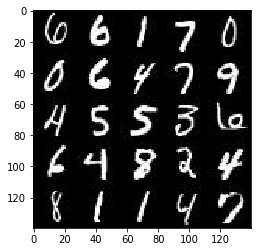

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

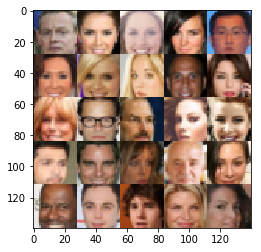

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real=tf.placeholder(tf.float32,[None,image_width,image_height,image_channels],name='input_real')
    input_z=tf.placeholder(tf.float32,[None,z_dim],name='input_z')
    learning_rate=tf.placeholder(tf.float32,name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.01
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
    
        #conv 1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        #conv2
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        
        #conv3
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        
        #fullyconnected
        flaten = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flaten, 1)
        out = tf.sigmoid(logits)
        

        return (out,logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha=0.01
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape to start  
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
       
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        
        out = tf.tanh(logits)
 
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth=0.1
    
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake =discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*(1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake
        
    
    return (d_loss,g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    step=0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                #laten space 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})

                if step % 20 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
              
            


                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if step % 120 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3524... Generator Loss: 4.6684
Epoch 1/2... Discriminator Loss: 0.7905... Generator Loss: 2.8971
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 1.7667
Epoch 1/2... Discriminator Loss: 0.6064... Generator Loss: 1.7425
Epoch 1/2... Discriminator Loss: 1.6249... Generator Loss: 0.4791
Epoch 1/2... Discriminator Loss: 1.7600... Generator Loss: 0.4074


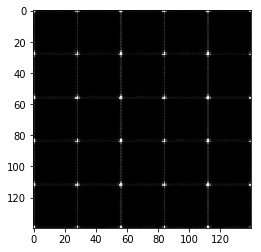

Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 0.7654
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.8097
Epoch 1/2... Discriminator Loss: 1.2497... Generator Loss: 0.8629
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.5682
Epoch 1/2... Discriminator Loss: 2.1198... Generator Loss: 0.2115


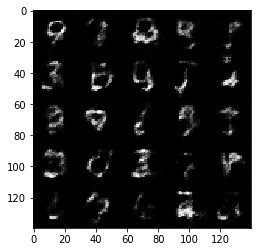

Epoch 1/2... Discriminator Loss: 1.7486... Generator Loss: 0.3779
Epoch 1/2... Discriminator Loss: 1.2251... Generator Loss: 0.9292
Epoch 1/2... Discriminator Loss: 1.2900... Generator Loss: 1.4444
Epoch 1/2... Discriminator Loss: 1.6127... Generator Loss: 0.4195
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 1.0735
Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 1.6150


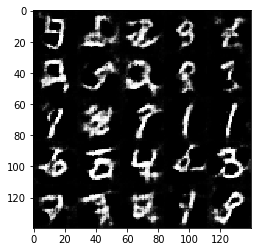

Epoch 1/2... Discriminator Loss: 1.3867... Generator Loss: 0.5366
Epoch 1/2... Discriminator Loss: 1.6430... Generator Loss: 0.4053
Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 1.3993... Generator Loss: 0.5922
Epoch 1/2... Discriminator Loss: 1.3241... Generator Loss: 0.6861


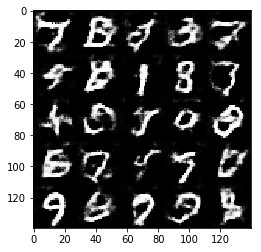

Epoch 1/2... Discriminator Loss: 1.1756... Generator Loss: 0.9057
Epoch 1/2... Discriminator Loss: 1.3265... Generator Loss: 0.9072
Epoch 1/2... Discriminator Loss: 1.5763... Generator Loss: 0.4441
Epoch 1/2... Discriminator Loss: 1.2205... Generator Loss: 0.6600
Epoch 1/2... Discriminator Loss: 1.1309... Generator Loss: 0.9731
Epoch 1/2... Discriminator Loss: 1.1563... Generator Loss: 0.9618


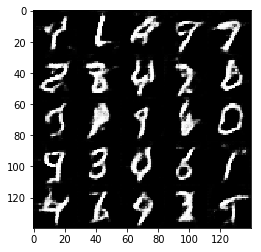

Epoch 1/2... Discriminator Loss: 1.7120... Generator Loss: 0.3893
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 0.5399
Epoch 1/2... Discriminator Loss: 1.0974... Generator Loss: 0.8405
Epoch 1/2... Discriminator Loss: 1.2477... Generator Loss: 0.6541
Epoch 1/2... Discriminator Loss: 1.0698... Generator Loss: 1.0271


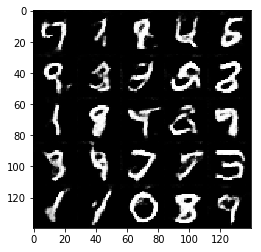

Epoch 1/2... Discriminator Loss: 1.0950... Generator Loss: 0.8552
Epoch 1/2... Discriminator Loss: 1.4303... Generator Loss: 0.4902
Epoch 1/2... Discriminator Loss: 1.3195... Generator Loss: 2.5133
Epoch 1/2... Discriminator Loss: 0.9212... Generator Loss: 1.2749
Epoch 1/2... Discriminator Loss: 1.1726... Generator Loss: 0.9556
Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 0.5752


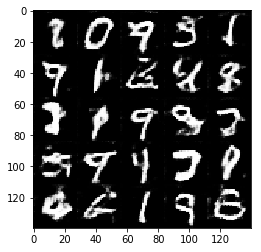

Epoch 1/2... Discriminator Loss: 1.0524... Generator Loss: 0.8868
Epoch 1/2... Discriminator Loss: 1.1372... Generator Loss: 1.2610
Epoch 1/2... Discriminator Loss: 1.3348... Generator Loss: 0.5461
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 1.8403
Epoch 1/2... Discriminator Loss: 1.0415... Generator Loss: 1.0701
Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 1.0784


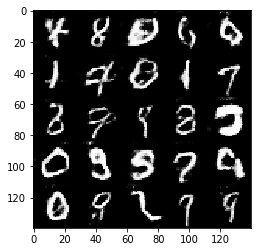

Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 1.1631
Epoch 1/2... Discriminator Loss: 1.0676... Generator Loss: 0.9304
Epoch 1/2... Discriminator Loss: 0.9896... Generator Loss: 0.8921
Epoch 1/2... Discriminator Loss: 1.3326... Generator Loss: 0.5579
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 1.3751
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 0.9130


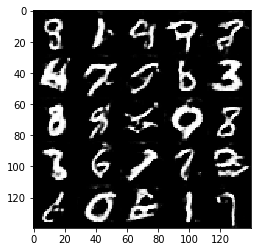

Epoch 1/2... Discriminator Loss: 1.3363... Generator Loss: 0.6052
Epoch 1/2... Discriminator Loss: 1.1115... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 1.3011... Generator Loss: 0.9324
Epoch 1/2... Discriminator Loss: 1.2078... Generator Loss: 0.6684
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 0.9846... Generator Loss: 0.9653


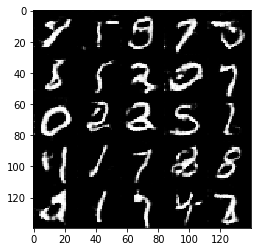

Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 0.6443
Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 1.3394
Epoch 1/2... Discriminator Loss: 1.0397... Generator Loss: 1.0288
Epoch 1/2... Discriminator Loss: 1.2394... Generator Loss: 0.6773
Epoch 1/2... Discriminator Loss: 0.9152... Generator Loss: 1.3379
Epoch 1/2... Discriminator Loss: 0.8995... Generator Loss: 0.9953


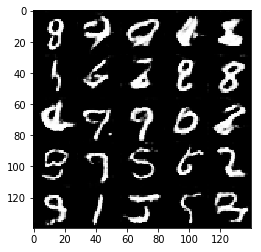

Epoch 1/2... Discriminator Loss: 1.0661... Generator Loss: 0.8175
Epoch 1/2... Discriminator Loss: 1.1256... Generator Loss: 0.7387
Epoch 1/2... Discriminator Loss: 0.8816... Generator Loss: 1.3888
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.6189
Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 0.8905
Epoch 1/2... Discriminator Loss: 1.0105... Generator Loss: 0.8706


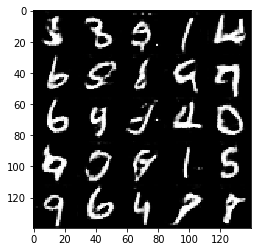

Epoch 1/2... Discriminator Loss: 1.0019... Generator Loss: 0.8886
Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 0.9297
Epoch 1/2... Discriminator Loss: 0.7296... Generator Loss: 1.5160
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.5796
Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 0.5117
Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.5575


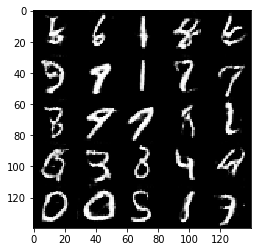

Epoch 1/2... Discriminator Loss: 1.5384... Generator Loss: 0.4482
Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 0.9048
Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 0.7943
Epoch 1/2... Discriminator Loss: 0.8315... Generator Loss: 1.2957
Epoch 1/2... Discriminator Loss: 0.7360... Generator Loss: 1.8083
Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 1.4084


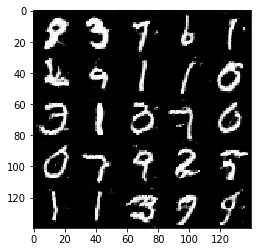

Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 0.9224
Epoch 1/2... Discriminator Loss: 1.1136... Generator Loss: 0.7397
Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 0.8424
Epoch 1/2... Discriminator Loss: 0.6446... Generator Loss: 1.7558
Epoch 1/2... Discriminator Loss: 0.7438... Generator Loss: 1.6317
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 0.5351


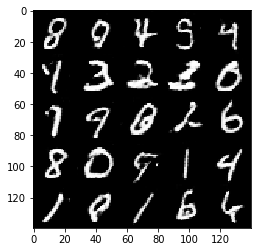

Epoch 1/2... Discriminator Loss: 0.8093... Generator Loss: 1.4237
Epoch 1/2... Discriminator Loss: 0.7510... Generator Loss: 1.3824
Epoch 1/2... Discriminator Loss: 0.9212... Generator Loss: 1.1201
Epoch 2/2... Discriminator Loss: 0.6657... Generator Loss: 1.7765
Epoch 2/2... Discriminator Loss: 0.8766... Generator Loss: 1.0985
Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 0.7807


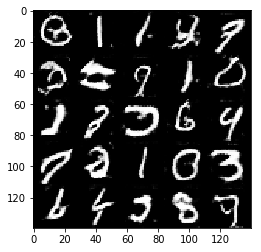

Epoch 2/2... Discriminator Loss: 1.3674... Generator Loss: 0.6014
Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 1.0589
Epoch 2/2... Discriminator Loss: 0.6034... Generator Loss: 1.8344
Epoch 2/2... Discriminator Loss: 0.6655... Generator Loss: 1.9738
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 0.8646
Epoch 2/2... Discriminator Loss: 1.0100... Generator Loss: 0.9460


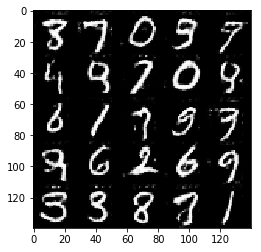

Epoch 2/2... Discriminator Loss: 1.0617... Generator Loss: 0.8260
Epoch 2/2... Discriminator Loss: 0.8405... Generator Loss: 1.1707
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 1.0593
Epoch 2/2... Discriminator Loss: 0.8261... Generator Loss: 1.2603
Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 1.5319
Epoch 2/2... Discriminator Loss: 0.5914... Generator Loss: 2.2065


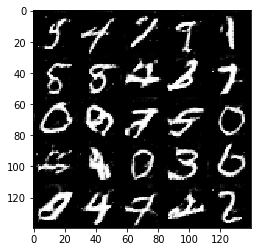

Epoch 2/2... Discriminator Loss: 1.4555... Generator Loss: 0.5240
Epoch 2/2... Discriminator Loss: 0.8153... Generator Loss: 1.2694
Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 1.8344
Epoch 2/2... Discriminator Loss: 0.8247... Generator Loss: 1.1868
Epoch 2/2... Discriminator Loss: 0.7234... Generator Loss: 1.5821
Epoch 2/2... Discriminator Loss: 1.8218... Generator Loss: 0.3472


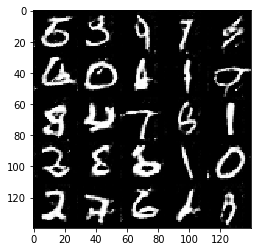

Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 1.0081
Epoch 2/2... Discriminator Loss: 1.0714... Generator Loss: 0.8732
Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 0.6978... Generator Loss: 1.5497
Epoch 2/2... Discriminator Loss: 0.8481... Generator Loss: 1.1739
Epoch 2/2... Discriminator Loss: 0.7347... Generator Loss: 1.8127


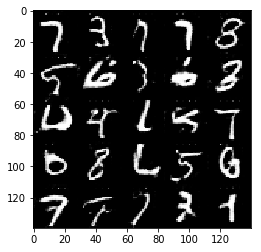

Epoch 2/2... Discriminator Loss: 0.7414... Generator Loss: 1.3230
Epoch 2/2... Discriminator Loss: 1.5775... Generator Loss: 0.4755
Epoch 2/2... Discriminator Loss: 0.6290... Generator Loss: 2.2948
Epoch 2/2... Discriminator Loss: 0.8169... Generator Loss: 1.2620
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 1.2726
Epoch 2/2... Discriminator Loss: 1.3114... Generator Loss: 0.6216


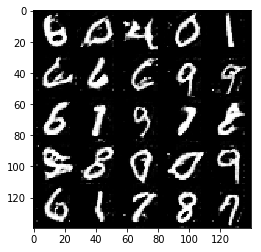

Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 0.8493
Epoch 2/2... Discriminator Loss: 0.7016... Generator Loss: 1.5687
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.4306
Epoch 2/2... Discriminator Loss: 1.5359... Generator Loss: 0.4849
Epoch 2/2... Discriminator Loss: 0.6910... Generator Loss: 1.4893


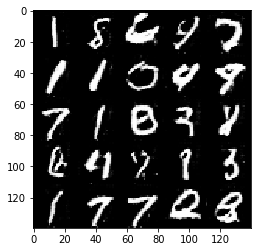

Epoch 2/2... Discriminator Loss: 0.7189... Generator Loss: 1.4481
Epoch 2/2... Discriminator Loss: 0.7496... Generator Loss: 1.3443
Epoch 2/2... Discriminator Loss: 0.8342... Generator Loss: 1.2575
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.7183
Epoch 2/2... Discriminator Loss: 0.9701... Generator Loss: 0.9636
Epoch 2/2... Discriminator Loss: 0.6636... Generator Loss: 1.5578


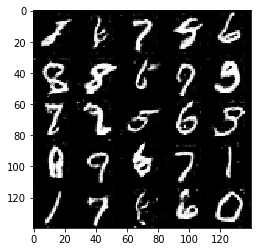

Epoch 2/2... Discriminator Loss: 0.7630... Generator Loss: 1.4316
Epoch 2/2... Discriminator Loss: 1.1576... Generator Loss: 0.8799
Epoch 2/2... Discriminator Loss: 0.7379... Generator Loss: 1.3294
Epoch 2/2... Discriminator Loss: 0.6894... Generator Loss: 1.5435
Epoch 2/2... Discriminator Loss: 0.7270... Generator Loss: 1.5498
Epoch 2/2... Discriminator Loss: 0.5708... Generator Loss: 2.3247


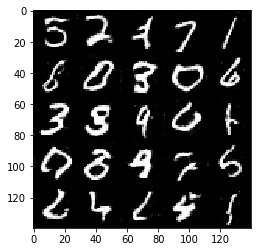

Epoch 2/2... Discriminator Loss: 0.6459... Generator Loss: 1.6473
Epoch 2/2... Discriminator Loss: 0.5994... Generator Loss: 2.4787
Epoch 2/2... Discriminator Loss: 0.9964... Generator Loss: 0.9611
Epoch 2/2... Discriminator Loss: 0.8244... Generator Loss: 1.2419
Epoch 2/2... Discriminator Loss: 0.5403... Generator Loss: 2.1137
Epoch 2/2... Discriminator Loss: 0.9708... Generator Loss: 0.9996


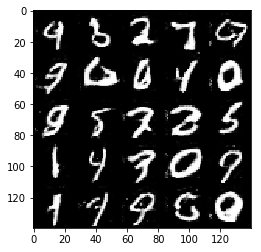

Epoch 2/2... Discriminator Loss: 1.0619... Generator Loss: 0.9021
Epoch 2/2... Discriminator Loss: 0.8691... Generator Loss: 1.0471
Epoch 2/2... Discriminator Loss: 1.1783... Generator Loss: 0.6578
Epoch 2/2... Discriminator Loss: 1.0284... Generator Loss: 0.9552
Epoch 2/2... Discriminator Loss: 1.0714... Generator Loss: 0.8106
Epoch 2/2... Discriminator Loss: 0.7904... Generator Loss: 1.3297


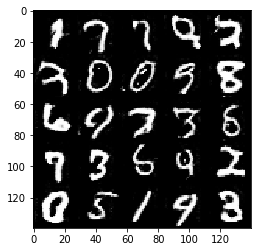

Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 1.0078
Epoch 2/2... Discriminator Loss: 0.6330... Generator Loss: 1.6232
Epoch 2/2... Discriminator Loss: 1.2958... Generator Loss: 0.7902
Epoch 2/2... Discriminator Loss: 0.6288... Generator Loss: 1.5304
Epoch 2/2... Discriminator Loss: 0.7530... Generator Loss: 1.3507
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.6207


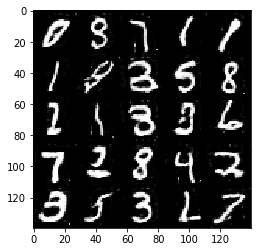

Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 1.6738
Epoch 2/2... Discriminator Loss: 0.7654... Generator Loss: 1.7509
Epoch 2/2... Discriminator Loss: 0.7483... Generator Loss: 1.4997
Epoch 2/2... Discriminator Loss: 1.0185... Generator Loss: 0.8819
Epoch 2/2... Discriminator Loss: 0.9370... Generator Loss: 0.9579
Epoch 2/2... Discriminator Loss: 0.5305... Generator Loss: 2.2291


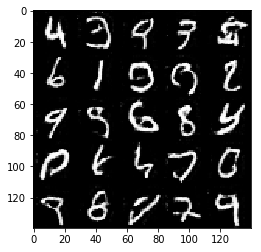

Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 0.9936
Epoch 2/2... Discriminator Loss: 0.6046... Generator Loss: 2.1088
Epoch 2/2... Discriminator Loss: 0.7742... Generator Loss: 1.2242
Epoch 2/2... Discriminator Loss: 0.7895... Generator Loss: 1.5979
Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 0.9675
Epoch 2/2... Discriminator Loss: 0.6157... Generator Loss: 1.8450


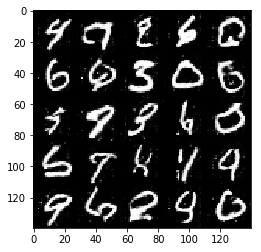

Epoch 2/2... Discriminator Loss: 0.6255... Generator Loss: 1.9183
Epoch 2/2... Discriminator Loss: 0.6867... Generator Loss: 1.4723
Epoch 2/2... Discriminator Loss: 0.7311... Generator Loss: 1.7697
Epoch 2/2... Discriminator Loss: 1.0013... Generator Loss: 0.9721
Epoch 2/2... Discriminator Loss: 0.7498... Generator Loss: 1.4928
Epoch 2/2... Discriminator Loss: 0.9308... Generator Loss: 1.1181


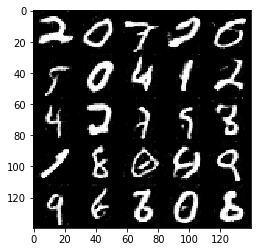

Epoch 2/2... Discriminator Loss: 0.6928... Generator Loss: 1.5397
Epoch 2/2... Discriminator Loss: 0.6614... Generator Loss: 1.6362
Epoch 2/2... Discriminator Loss: 0.5720... Generator Loss: 2.4924
Epoch 2/2... Discriminator Loss: 0.7636... Generator Loss: 1.6796
Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 0.7727
Epoch 2/2... Discriminator Loss: 0.7584... Generator Loss: 1.4939


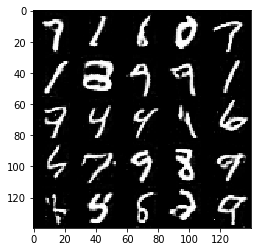

Epoch 2/2... Discriminator Loss: 0.6997... Generator Loss: 1.4024


In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4156... Generator Loss: 3.7593
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 12.8548
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.1656
Epoch 1/1... Discriminator Loss: 2.5356... Generator Loss: 0.1760
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 5.4253
Epoch 1/1... Discriminator Loss: 0.4020... Generator Loss: 4.6396


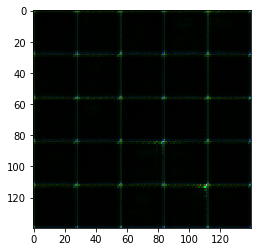

Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 8.4255
Epoch 1/1... Discriminator Loss: 2.2431... Generator Loss: 7.1189
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.6480
Epoch 1/1... Discriminator Loss: 1.7063... Generator Loss: 5.9291


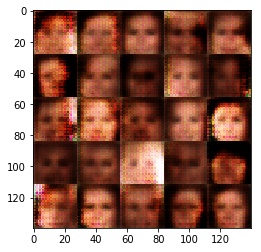

Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 2.0213
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 1.9588
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.5570
Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 1.9068


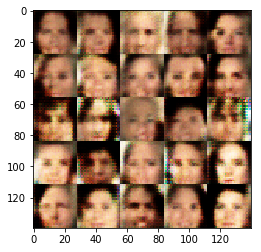

Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 2.0355
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.0410
Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 2.9595
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 0.9515
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.1805


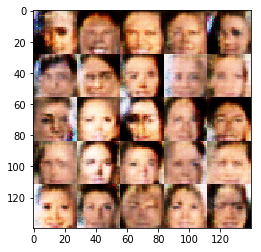

Epoch 1/1... Discriminator Loss: 1.8401... Generator Loss: 2.9903
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.2841
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.4983
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 1.2281
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.7029


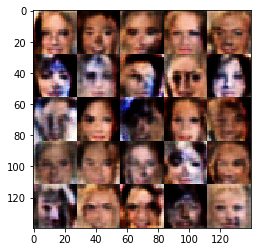

Epoch 1/1... Discriminator Loss: 1.7441... Generator Loss: 0.3958
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 2.1582
Epoch 1/1... Discriminator Loss: 0.8602... Generator Loss: 1.5651
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 2.1594
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.6886


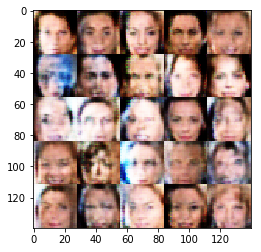

Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 1.6150
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 2.0772
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 2.1688
Epoch 1/1... Discriminator Loss: 0.7260... Generator Loss: 1.5463
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 1.4632


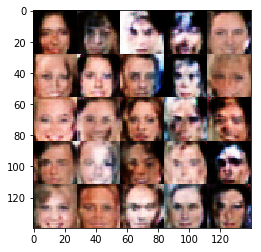

Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.8649... Generator Loss: 0.2813
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.4438
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5513


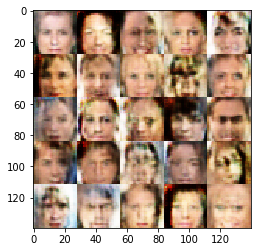

Epoch 1/1... Discriminator Loss: 0.4377... Generator Loss: 2.8627
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 1.1459
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 2.0976
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.9205


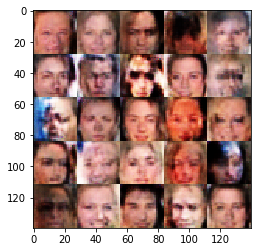

Epoch 1/1... Discriminator Loss: 1.9011... Generator Loss: 0.2722
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 2.4512
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.6940


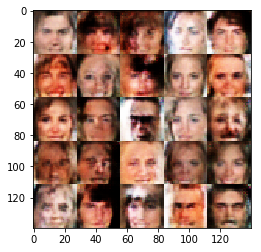

Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 1.5762
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 1.0496


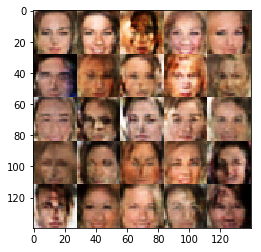

Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.1872
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 1.2727
Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 1.8127
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 1.8210


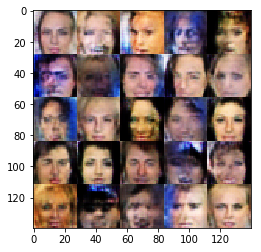

Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.4684
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 0.4521... Generator Loss: 4.0823
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 2.0671
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.3457


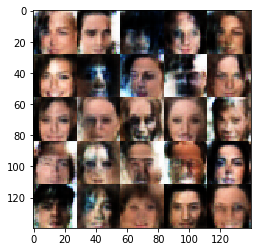

Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.4330
Epoch 1/1... Discriminator Loss: 1.6164... Generator Loss: 0.4203
Epoch 1/1... Discriminator Loss: 1.6648... Generator Loss: 0.3694
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.8539


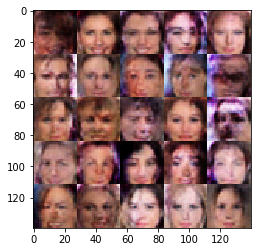

Epoch 1/1... Discriminator Loss: 1.8299... Generator Loss: 0.3798
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.6158... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.9152


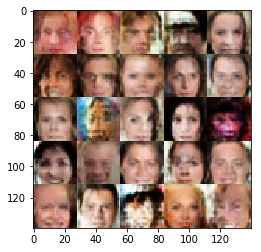

Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.4825
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.5074
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7192


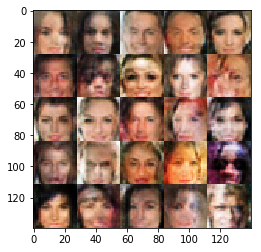

Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.8562


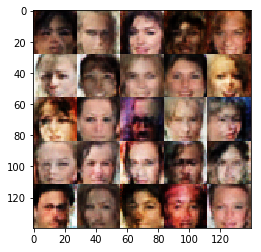

Epoch 1/1... Discriminator Loss: 1.6259... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.8204


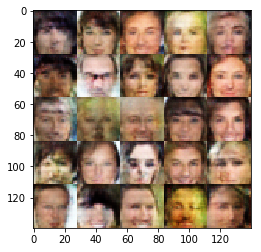

Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.9599


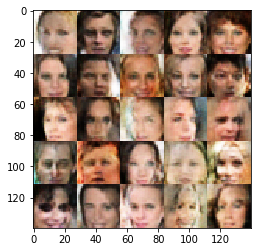

Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 1.0914
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.3716
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.8224


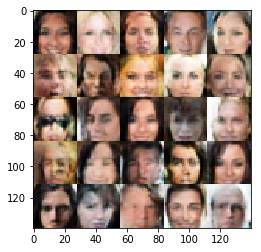

Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.5099
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.5654


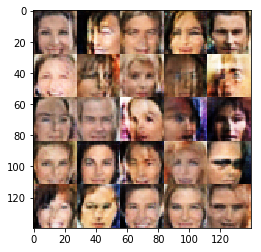

Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.7256... Generator Loss: 0.5970


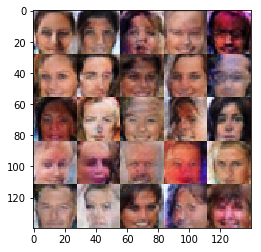

Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.5045
Epoch 1/1... Discriminator Loss: 1.7281... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.7464


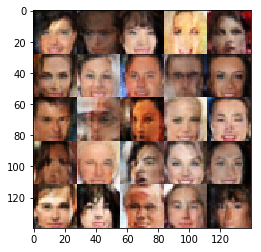

Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.6018


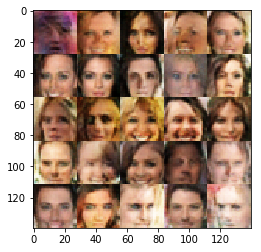

Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 0.4391
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.6679


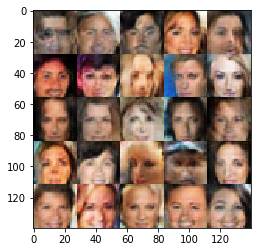

Epoch 1/1... Discriminator Loss: 1.6609... Generator Loss: 0.4152
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.4663
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.6886


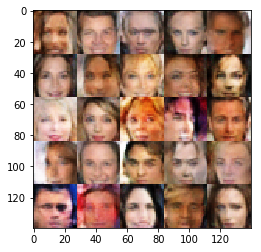

Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.6090... Generator Loss: 0.4919


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.